In [3]:
import json
import csv
import threading
import math
import pandas as pd
import numpy as np
import multiprocessing
import random as rn

import seaborn as sns
import matplotlib.pyplot as plt



# from data import data_visualization, data_loading, data_preprocessing
# from models import annModels

# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.model_selection import  learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier

# import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Activation
from keras.optimizers import SGD
from keras.models import load_model
from keras import regularizers
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.layers import concatenate
from sklearn.model_selection import StratifiedKFold

import joblib

2024-08-24 16:54:05.678688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-24 16:54:05.692704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 16:54:05.709251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 16:54:05.713649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 16:54:05.726641: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Load and preprocess data
def load_data():
    df = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/final_dataset.csv')
    X = df.drop(['label', 'Unnamed: 0'], axis=True).values
    y = df['label'].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    return X_train, X_test, y_train, y_test, X_val, y_val

X_train, X_test, y_train, y_test, X_val, y_val = load_data()

# Reshape data for Conv2D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Build and compile the 2D CNN model
def build_2d_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Adjust dropout rate
    model.add(Dense(2, activation='softmax'))  # 2 units for binary classification
    
    # Compile model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (41, 1, 1)
model_2d_cnn = build_2d_cnn(input_shape)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/cnn_2d_final_binary_base_classifier.keras', 
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=False, 
    mode='min', 
    verbose=1
)

# Train the model
history_2d_cnn = model_2d_cnn.fit(X_train, y_train,
                                  epochs=50,
                                  batch_size=32,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, model_checkpoint])

# Make predictions on the test set
y_pred_prob = model_2d_cnn.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred)
recall = recall_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred)

# Print results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# # Plot training and validation loss
# plt.figure(figsize=(12, 5))

# # plt.subplot(1, 2, 1)
# plt.plot(history_2d_cnn.history['loss'], label='Training Loss')
# plt.plot(history_2d_cnn.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.gca().set_facecolor('lightgrey')

# # Optional: Visualize the confusion matrix
# plt.subplot(1, 2, 2)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# # plt.title('Confusion Matrix')

# plt.show()


Epoch 1/50


2024-08-24 16:54:16.884582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13888 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:47:00.0, compute capability: 8.6
I0000 00:00:1724498657.769600  556774 service.cc:146] XLA service 0x7b2054005a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724498657.769632  556774 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-08-24 16:54:17.788943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-24 16:54:17.881221: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 157/9422 ━━━━━━━━━━━━━━━━━━━━ 9s 973us/step - accuracy: 0.6367 - loss: 0.6128

I0000 00:00:1724498659.183357  556774 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9422/9422 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.8340 - loss: 0.3603
Epoch 1: val_loss improved from inf to 0.22367, saving model to /home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/cnn_2d_final_binary_base_classifier.keras
9422/9422 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8340 - loss: 0.3603 - val_accuracy: 0.9047 - val_loss: 0.2237
Epoch 2/50
9408/9422 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9012 - loss: 0.2361
Epoch 2: val_loss improved from 0.22367 to 0.19840, saving model to /home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/cnn_2d_final_binary_base_classifier.keras
9422/9422 ━━━━━━━━━━━━━━━━━━━━ 9s 935us/step - accuracy: 0.9012 - loss: 0.2361 - val_accuracy: 0.9167 - val_loss: 0.1984
Epoch 3/50
9394/9422 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.9121 - loss: 0.2110
Epoch 3: val_loss improved from 0.19840 to 0.18916, saving model to /home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/cnn_2d_final_binary_base_classifier.keras
9422/9422

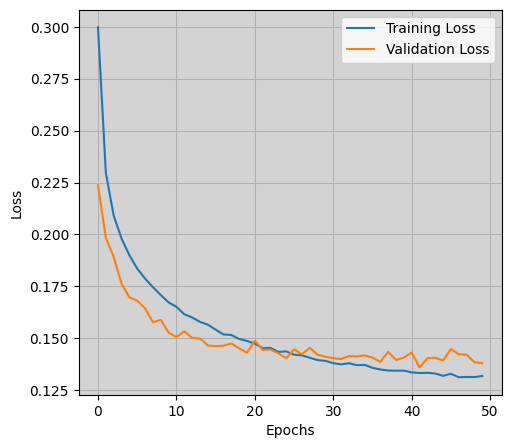

In [5]:
#Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2d_cnn.history['loss'], label='Training Loss')
plt.plot(history_2d_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('lightgrey')

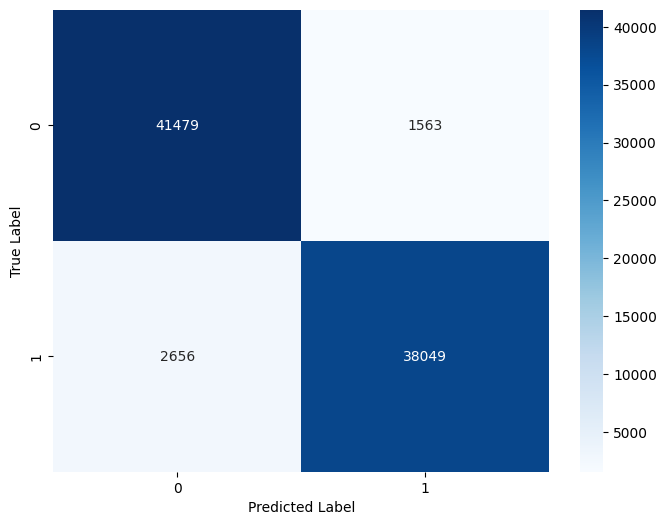

In [6]:
# Optional: Visualize the confusion matrix
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.title('Confusion Matrix')

plt.show()

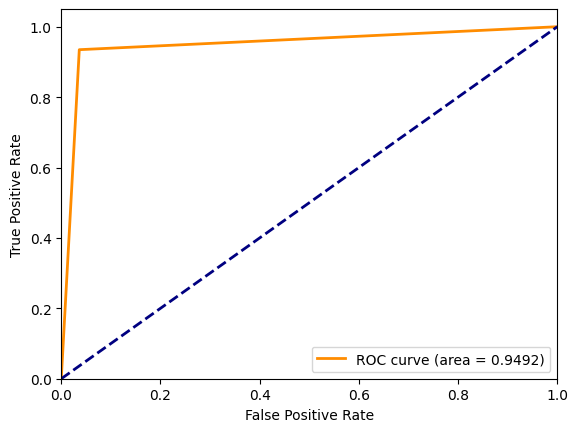

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, accuracy_score
 # Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [8]:
# Save the trained model
model_2d_cnn .save('/home/devnath/Ember_18_Aug/model_save/2dcnn_base_classfier.h5')

In [2]:
!kill 7471 

In [8]:
from tensorflow.keras.models import load_model

# Load the saved model
dcnn2_model = load_model('/home/devnath/Ember_18_Aug/model_save/2dcnn_base_classfier.h5')


2024-08-25 16:12:32.956728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13888 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:47:00.0, compute capability: 8.6


In [9]:
dcnn2_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 39, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,260 (282.27 KB)

 Trainable params: 72,258 (282.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
!nvidia-smi

Sun Aug 25 16:11:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               Off | 00000000:47:00.0 Off |                  Off |
| 41%   37C    P8              15W / 140W |  16097MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!kill 556637